# Summary of Available Sensorimotor and Interest Models

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In this notebook, we summarize the different sensorimotor and interest models available in the Explauto library, and give some explanations or references. We suppose that the reader is familiar with the main components of the Explauto library explained in another notebook ([full tutorial](http://nbviewer.ipython.org/github/flowersteam/explauto/blob/master/notebook/full_tutorial.ipynb)): the environment, the sensorimotor model and the interest model.

Let's begin with defining a simple environment that will be used to test the sensorimotor models.

In [2]:
from explauto.environment.environment import Environment
environment = Environment.from_configuration('simple_arm', 'mid_dimensional')

/Users/catherinehenry/School/Thesis/explauto_fork/explauto/explauto/sensorimotor_model/inverse/cma.py:1730: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  elif self.scales.shape is not () and len(self.scales) != self.N:
/Users/catherinehenry/School/Thesis/explauto_fork/explauto/explauto/sensorimotor_model/inverse/cma.py:1737: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  elif self.typical_x.shape is not () and len(self.typical_x) != self.N:
/Users/catherinehenry/School/Thesis/explauto_fork/explauto/explauto/sensorimotor_model/inverse/cma.py:1741: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if (self.scales is 1 and
/Users/catherinehenry/School/Thesis/explauto_fork/explauto/explauto/sensorimotor_model/inverse/cma.py:1742: SyntaxWarning: "is" with a literal. Did you mean "=="?
  self.typical_x is 0 and
/Users/catherinehenry/School/Thesis/explauto_fork/explauto/explauto/sensorimotor_model/inverse/cma.py:1787: SyntaxWarning: "is not" with a literal.

simple_arm
pendulum
npendulum


# Sensorimotor models

In Explauto, a sensorimotor model implements both the iterative learning process from sensorimotor experience, i.e. from the iterative collection of $(m, s)$ pairs by interaction with the environment, and the use of the resulting internal model to perform forward and inverse predictions (or any kind of general prediction between sensorimotor subspaces). 

Learning sensorimotor mappings involves machine learning algorithms, for which Explauto provides a unified interface through the [SensorimotorModel abstract class](http://flowersteam.github.io/explauto/explauto.sensorimotormodel.html#explauto.sensorimotor_model.sensorimotor_model.SensorimotorModel). 

Using the simple arm environment above, it allows to iteratively learn a sensorimotor model which will be able to:
* infer the position of the end-effector from a given motor command, what is called *forward prediction*,
* infer the motor command allowing to reach a particular end-effector position, what is called *inverse prediction*.
* update online from sensorimotor experience

Several sensorimotor models are provided: simple nearest-neighbor look-up, non-parametric models combining classical regressions and optimization algorithms, online local mixtures of Gaussians (beta). Here we will only explain non-parametric models.

Non-parametric models can be decomposed into a dataset, a forward model, and an inverse model. 

The dataset just stores all the experiments (m, s) into a list.

The forward model uses the dataset for the forward prediction computation, and the inverse model uses the forward model, or directly the dataset to perform inverse prediction.

All the non-parametric sensorimotor models have two operating modes: "explore" and "exploit".

In the "explore" mode, when the agent asks for the exact inverse prediction $m$ of a goal $s_g$, $m$ will be perturbated with some gaussian exploration noise in order to allow the agent to explore new motor commands. The sensorimotor models thus have a common parameter: sigma_explo_ratio=0.1 (default), which is the standard deviation of the gaussian noise, scaled depending of the motor domain size: if a motor value is bounded in [-2:2], then a sigma_explo_ratio of 0.1 will induce an exploration noise of (m_max - m_min) * sigma_explo_ratio = 0.4

In the "exploit" mode, no exploration noise is added. This mode is used for instance when evaluating the inverse model for comparison purposes.

## Forward Models:

Forward models predict $s_p$ given a $m$ that might have never been observed, using the dataset of observations $(m,s)$.

### NN Forward model

To perform a forward prediction, the Nearest Neighbor model just look in the dataset of tuples $(m, s)$, the nearest neighbor of the given $m$ motor command, and return its corresponding $s$.
This forward model is very fast (up to datasets of size $10^5$), and makes no assumptions about the regularity of the model being learned (continuity, linearity, ...). It works sufficiently well in different typical robotic applications.

### WNN Forward model

To perform a forward prediction of $m$, the Weighted Nearest Neighbor model looks at the $k$ (parameter) nearest neighbors of $m$ in the dataset, and returns the average of the $k$ corresponding $s$. This average is weighted by the distance to $m$ with a gaussian of standard deviation $\sigma$ (parameter).

See [k-nearest neighbors algorithm](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm).

### LWLR Forward model

The Locally Weigthed Linear Regression (LWLR) computes a linear regression of the $k$ nearest neighbors of $m$ (thus a local regression), and find the requested $s$ with the given $m$ based on that regression.

References :
1. https://en.wikipedia.org/wiki/Local_regression
2. C. G. Atkeson, A. W. Moore, S. Schaal, "[Locally Weighted Learning for Control](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.468.7121&rep=rep1&type=pdf)", "Springer Netherlands", 75-117, vol 11, issue 1, 1997/02, 10.1023/A:1006511328852    
3. See also a [video](http://www.cosmolearning.com/video-lectures/locally-weighted-regression-probabilistic-interpretation-logistic-regression/) lecture on LWR.

Pseudo Code :


In [3]:
"""
Input D problem dimension
Input X matrix of inputs:  X[k][i] = i’th component of k’th input point.
Input Y matrix of outputs: Y[k] = k’th output value.
Input xq = query input.    Input kwidth.

WXTWX = empty (D+1) x (D+1) matrix
WXTWY = empty (D+1) x 1     matrix

for ( k = 0 ; i <= N - 1 ; i = i + 1 )
    # Compute weight of kth point
    wk = weight_function( distance( xq , X[k] ) / kwidth )

    /* Add to (WX) ^T (WX) matrix */
    for ( i = 0 ; i <= D ; i = i + 1 )
        for ( j = 0 ; j <= D ; j = j + 1 )
            if ( i == 0 )
                xki = 1 else xki = X[k] [i]
            if ( j == 0 )
                xkj = 1 else xkj = X[k] [j]
            WXTWX [i] [j] = WXTWX [i] [j] + wk * wk * xki * xkj

    /*  Add to (WX) ^T (WY) vector */
    for ( i = 0 ; i <= D ; i = i + 1 )
        if ( i == 0 )
            xki = 1 else xki = X[k] [i]
        WXTWY [i] = WXTWY [i] + wk * wk * xki * Y[k]

/* Compute the local beta.  Call your favorite linear equation solver.
   Recommend Cholesky Decomposition for speed.
   Recommend Singular Val Decomp for Robustness. */

Beta = (WXTWX)^{-1}(WXTWY)

Output ypredict = beta[0] + beta[1]*xq[1] + beta[2]*xq[2] + … beta[D]*x q[D]
"""

'\nInput D problem dimension\nInput X matrix of inputs:  X[k][i] = i’th component of k’th input point.\nInput Y matrix of outputs: Y[k] = k’th output value.\nInput xq = query input.    Input kwidth.\n\nWXTWX = empty (D+1) x (D+1) matrix\nWXTWY = empty (D+1) x 1     matrix\n\nfor ( k = 0 ; i <= N - 1 ; i = i + 1 )\n    # Compute weight of kth point\n    wk = weight_function( distance( xq , X[k] ) / kwidth )\n\n    /* Add to (WX) ^T (WX) matrix */\n    for ( i = 0 ; i <= D ; i = i + 1 )\n        for ( j = 0 ; j <= D ; j = j + 1 )\n            if ( i == 0 )\n                xki = 1 else xki = X[k] [i]\n            if ( j == 0 )\n                xkj = 1 else xkj = X[k] [j]\n            WXTWX [i] [j] = WXTWX [i] [j] + wk * wk * xki * xkj\n\n    /*  Add to (WX) ^T (WY) vector */\n    for ( i = 0 ; i <= D ; i = i + 1 )\n        if ( i == 0 )\n            xki = 1 else xki = X[k] [i]\n        WXTWY [i] = WXTWY [i] + wk * wk * xki * Y[k]\n\n/* Compute the local beta.  Call your favorite linear e

### Forward models for Non-Stationnary environments

'NSNN' and 'NSLWLR' are modified versions of 'NN' and 'LWLR' where points are not only weighted by distance but also by the number of points that appeared after that one (gaussian with parameter sigma_t=100), to put less weight on old points and allow the learning of Non-Stationnary environments.

## Inverse Models

Inverse models infer a motor command $m$ that should be able to reach a given goal $s_g$.

### NN Inverse Model

To perform the inverse inference, the Nearest Neighbor inverse model just look in the dataset of tuples $(m, s)$, the nearest neighbor of the given $s$ motor command, and return its corresponding $m$.

### WNN Inverse Model

Typical robotic forward models are very redundant: e.g. a robotic arm can put its hand to position $s$ with an infinity of possible $m$ motor positions.
Thus, trying to infer a motor command $m$ to reach a given goal $s$ doing an average of the nearest neighbors of $s$ in the dataset would make no sense as those nearest neighbors might have very different corresponding motor commands.

To perform the inverse inference of a given $s$, the Weighted Nearest Neighbor model looks at the nearest neighbor of $s$ in the dataset and gets its corresponding $m$. It finds now the $k$ (parameter) nearest neighbors of $m$ in the dataset, and returns their average weighted by the distance of their sensory part to $s$, with a gaussian of standard deviation $\sigma$ (parameter).

See code [here](https://github.com/flowersteam/explauto/blob/master/explauto/sensorimotor_model/inverse/wnn.py#L25).

### Optimization Inverse model

Another possibility to perform inverse inference is to use an optimization algorithm to minimize the error  $e(x) = ||f(x) - y_g||^2$  where $y_g$ is the goal, $f$ is the forward model, and $x$ is the motor command to be infered.

This is how our [scipy.optimize based](https://github.com/flowersteam/explauto/blob/master/explauto/sensorimotor_model/inverse/sciopt.py#L8) inverse models do. 

The adapted ones are 'COBYLA' ([wikipedia](https://en.wikipedia.org/wiki/COBYLA)), 'BFGS' and 'L-BFGS-B' ([wikipedia](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm)).

They take a 'maxfun' (BFGS) or 'maxiter' (COBYLA) parameter that limits the number of error function (and so forward model) evaluation.

'CMAES' Inverse model (Covariance Matrix Adaptation - Evolutionary Strategy) also optimizes that error function but makes fewer assumptions on the regularity of the forward model to perform the search. It is based on a random exploration (with a computed covariance) around a current point of interest, and adapts this point and recompute the covariance matrix at each iteration, with memory of the taken path.
The initial point is set as the motor part $m$ of the nearest neighbor $s$ of the goal $s_g$, and the initial covariance matrix is identity times an exploration $\sigma$ (parameter). This inverse model also takes a 'maxfevals' parameter that limits the number of forward model evaluations.

See [Hansen's website](https://www.lri.fr/~hansen/cmaesintro.html) and this [tutorial](https://www.lri.fr/~hansen/cmatutorial.pdf) on CMA-ES.

## Combinations of one forward and one inverse model: the sensorimotor model

Combinations of a forward and an inverse model can be instanciated using 'fwd' and 'inv' options.

Possible 'fwd':  'NN', 'WNN', 'LWLR', 'NSNN', 'NSLWLR'

Possible 'inv':  'NN', 'WNN', 'BFGS', 'L-BFGS-B', 'COBYLA', 'CMAES', 'Jacobian'

Here are the already provided combinations:

In [4]:
from explauto.sensorimotor_model import sensorimotor_models, available_configurations
sensorimotor_models.keys()

dict_keys(['nearest_neighbor', 'WNN', 'LWLR-BFGS', 'LWLR-CMAES'])

For each combination, we can use one of the possible configurations (use available_configurations to find them), or we can define our own configuration. See the following for some exemples.

### 'nearest_neighbor'

In [5]:
available_configurations('nearest_neighbor')

{'default': {'fwd': 'NN', 'inv': 'NN', 'sigma_explo_ratio': 0.1},
 'exact': {'fwd': 'NN', 'inv': 'NN', 'sigma_explo_ratio': 0.0}}

In [6]:
from explauto.sensorimotor_model.sensorimotor_model import SensorimotorModel
sm_model = SensorimotorModel.from_configuration(environment.conf, "nearest_neighbor", "default")

We also can specify the parameters by hand:

In [7]:
from explauto.sensorimotor_model.non_parametric import NonParametric
params = {'fwd': 'NN', 'inv': 'NN', 'sigma_explo_ratio':0.1}
sm_model = NonParametric(environment.conf, **params)

### 'WNN'

In [8]:
params = {'fwd': 'WNN', 'inv': 'WNN', 'k':20, 'sigma':0.1, 'sigma_explo_ratio':0.1}
sm_model = NonParametric(environment.conf, **params)

### 'LWLR-BFGS'

In [9]:
params = {'fwd': 'LWLR', 'k':10, 'inv': 'L-BFGS-B', 'maxfun':50}
sm_model = NonParametric(environment.conf, **params)

### 'LWLR-CMAES'

In [10]:
params = {'fwd': 'LWLR', 'k':10, 'inv': 'CMAES', 'cmaes_sigma':0.05, 'maxfevals':20}
sm_model = NonParametric(environment.conf, **params)

## Simple test

Choose a sensorimotor model and try the following test.

Inferred motor command to reach the position  [0.7, 0.5] :  [ 0.58665269 -0.62262917  0.76453667 -0.16664151  1.01778078  0.16181558
  0.35025936]


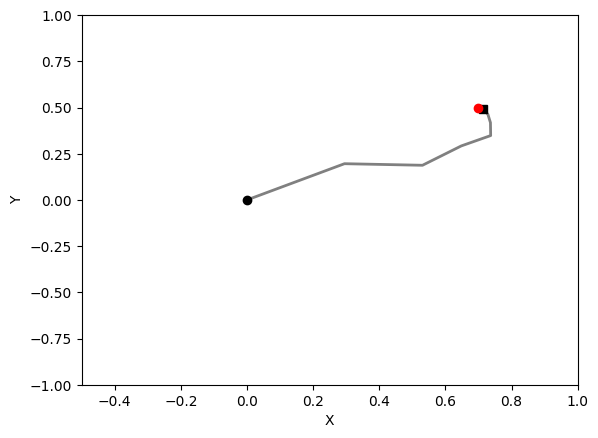

In [16]:
for m in environment.random_motors(n=1000):
    # compute the sensori effect s of the motor command m through the environment:
    s = environment.compute_sensori_effect(m)
    # update the model according to this experience:
    sm_model.update(m, s)
    
sm_model.mode = "exploit"
s_g = [0.7, 0.5]
m = sm_model.inverse_prediction(s_g)
print('Inferred motor command to reach the position ', s_g, ': ', m)

ax = plt.axes()
environment.plot_arm(ax, m)
ax.plot(*s_g, marker='o', color='red')

# Interest models

In Explauto, the role of interest models is to provide sensorimotor predictions (forward or inverse) to be performed by the sensorimotor model. An interest model implements the active exploration process,  where sensorimotor experiments are chosen to improve the forward or inverse predictions of the sensorimotor model. It explores in a given *interest space* resulting in motor babbling strategies when it corresponds to the motor space and in goal babbling strategies when it corresponds to the sensory space.

An interest model has to implement a sampling procedure in the interest space. Explauto provides several sampling procedures: 
* random sampling ('random'),
* learning progress maximization in forward or inverse predictions, with a fixed discretization of the interest space ('discretized_progress'),
* learning progress maximization in forward or inverse predictions, with an adating discretization of the interest space ('tree').
    
    
At each iteration, a goal is selected by the interest model, the sensorimotor model tries to reach that goal, and the distance between the actual reached point and the goal serves to compute the competence on that goal.

See this [notebook](http://nbviewer.ipython.org/github/flowersteam/explauto/blob/master/notebook/introducing_curiosity_learning.ipynb) for a comparison of 'random', 'discretized_progress' and 'tree' interest models.

In [17]:
from explauto.interest_model import interest_models, available_configurations
interest_models.keys()

dict_keys(['random', 'misc_random', 'gmm_progress_beta', 'discretized_progress', 'tree'])

We can get the default parameters of one of the algorithms with available_configuration:

In [18]:
available_configurations('discretized_progress')

{'default': {'x_card': 400,
  'win_size': 10,
  'eps_random': 0.3,
  'measure': <function explauto.interest_model.competences.competence_dist(target, reached, dist_min=0.0, dist_max=1.0)>}}

### 'random'

The random interest model just draw random goals in the interest space.

In [19]:
from explauto import InterestModel
im_model = InterestModel.from_configuration(environment.conf, environment.conf.s_dims, 'random')

### 'discretized_progress'

The 'discretized_progress' interest model is based on the computation of the interest as the absolute derivative of the competence in each region of a fixed discretization of the interest space. 'x_card' is the total number of cells in the discretization. 'win_size' is the window size of the interest computation which is based on the last 'win_size' points.


In [26]:
from explauto.interest_model.discrete_progress import DiscretizedProgress, competence_dist

im_model = DiscretizedProgress(environment.conf, environment.conf.s_dims, **{'x_card': 1000,
                                                                             'win_size': 10,
                                                                             'measure': competence_dist,
                                                                             'eps_random': False}) # TODO: idk if this is actually a bool, look into it

### 'tree'

See [Baranes2012](http://www.sciencedirect.com/science/article/pii/S0921889012000644) for a presentation of the SAGG-RIAC algorithm. We re-implemented the algorithm [here](https://github.com/flowersteam/explauto/blob/master/explauto/interest_model/tree.py#L16) in python, with several implementation options.
The main idea is to adapt the discretization to the dataset distribution. At each iteration, if there is to much point in a region, that region is splitted in 2 subregions (along the next axis in a [kdtree](https://en.wikipedia.org/wiki/K-d_tree)-like way), choosing the value of the split in order to best discriminate the interest of the 2 subregions.

Here are the options:

* max_points_per_region : int:
    Maximum number of points per region. A given region is splited when this number is exceeded.
* max_depth : int:
    Maximum depth of the tree
* split_mode : string:
    Mode to split a region: 
        'random': random value between first and last points, 
        'median': median of the points in the region on the split dimension, 
        'middle': middle of the region on the split dimension, 
        'best_interest_diff': 
            value that maximize the difference of progress in the 2 sub-regions
            (described in Baranes2012: Active Learning of Inverse Models 
            with Intrinsically Motivated Goal Exploration in Robots)
* progress_win_size : int:
    Number of last points taken into account for progress computation (should be < max_points_per_region)
* progress_measure : string:
    How to compute progress: 
        'abs_deriv_cov': approach from explauto's discrete progress interest model
        'abs_deriv': absolute difference between first and last points in the window, 
        'abs_deriv_smooth', absolute difference between first and last half of the window 
* sampling_mode : list:
    How to sample a point in the tree: 
        dict(multiscale=bool, 
            volume=bool, 
            mode=greedy'|'random'|'epsilon_greedy'|'softmax', 
            param=float)                    
        multiscale: if we choose between all the nodes of the tree to sample a goal, leading to a multi-scale resolution
                    (described in Baranes2012: Active Learning of Inverse Models 
                    with Intrinsically Motivated Goal Exploration in Robots)
        volume: if we weight the progress of nodes with their volume to choose between them
                (new approach)
        mode: sampling mode
        param: a parameter of the sampling mode: eps for eps_greedy, temperature for softmax.         

In [24]:
from explauto.interest_model.tree import InterestTree, competence_exp

im_model = InterestTree(environment.conf, environment.conf.s_dims, **{'max_points_per_region': 100,
                                                                       'max_depth': 20,
                                                                       'split_mode': 'best_interest_diff',
                                                                       'competence_measure': lambda target,reached : competence_exp(target, reached, 0., 10.),
                                                                       'progress_win_size': 50,
                                                                       'progress_measure': 'abs_deriv_smooth',                                                     
                                                                       'sampling_mode': {'mode':'softmax', 
                                                                                         'param':0.2,
                                                                                         'multiscale':False,
                                                                                         'volume':True}})

### 'gmm_progress_beta'

This model computes a gaussian mixture model that represents at the same time the space of interest, the competence, and time (thus a mixture in $S\times C \times T$ space). To sample in an interesting region of S, the algorithm weights the gaussian components based on their covariance between $C$ and $T$, giving positive weight to a component if the competence increases with time in that region of $S$.

See [Moulin-Frier2013](https://flowers.inria.fr/FrontierscogSciJul13.pdf), page 9, for illustrations of this process.

In [25]:
from explauto.interest_model.gmm_progress import GmmInterest, competence_exp

im_model = GmmInterest(environment.conf, environment.conf.s_dims, **{'measure': competence_exp,
                                                                      'n_samples': 40,
                                                                      'n_components': 6})